In [91]:
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

SEED = 42
np.random.seed(SEED)

#### Importing training and test data

In [92]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [93]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Sale Price column is right skewed(See plot below). To make it normally distributed,we apply log tranform.

In [94]:
train['SalePrice_log'] = np.log1p(train['SalePrice'])

### Feature Engineering

We have to apply same operations on train and test both. Hence a function will make it more readable.

In [95]:
def add_features(df):
    df = df.copy()

    df['TotalSF'] = (df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'].fillna(0) + df['2ndFlrSF'].fillna(0))

    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']

    df['HasPool'] = (df['PoolArea'].fillna(0) > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)

    return df


In [96]:
# Apply feature engineering to train and test
train = add_features(train)
test = add_features(test)

### Data Visualization

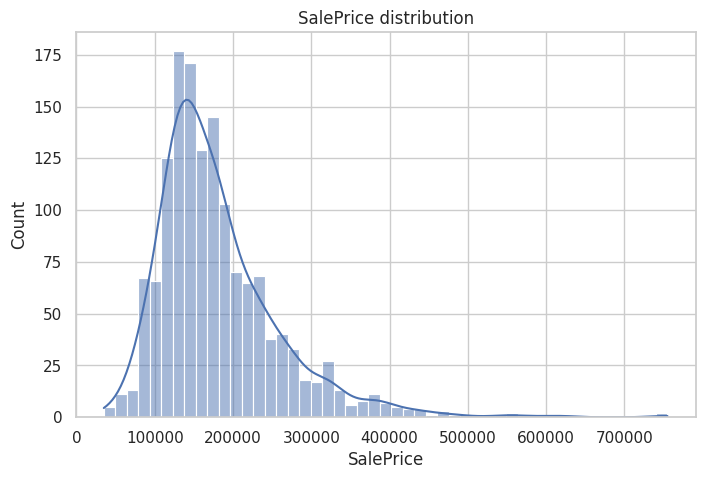

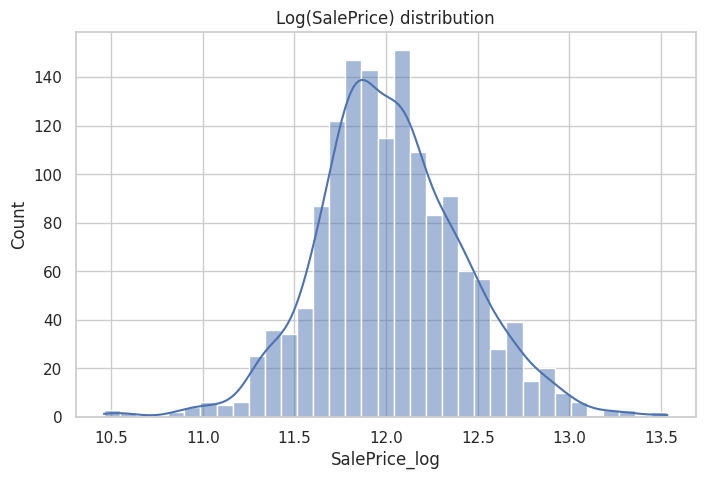

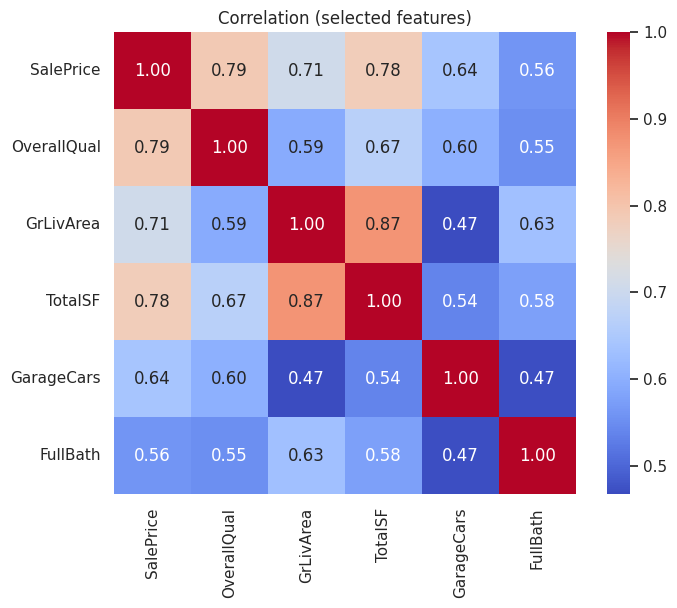

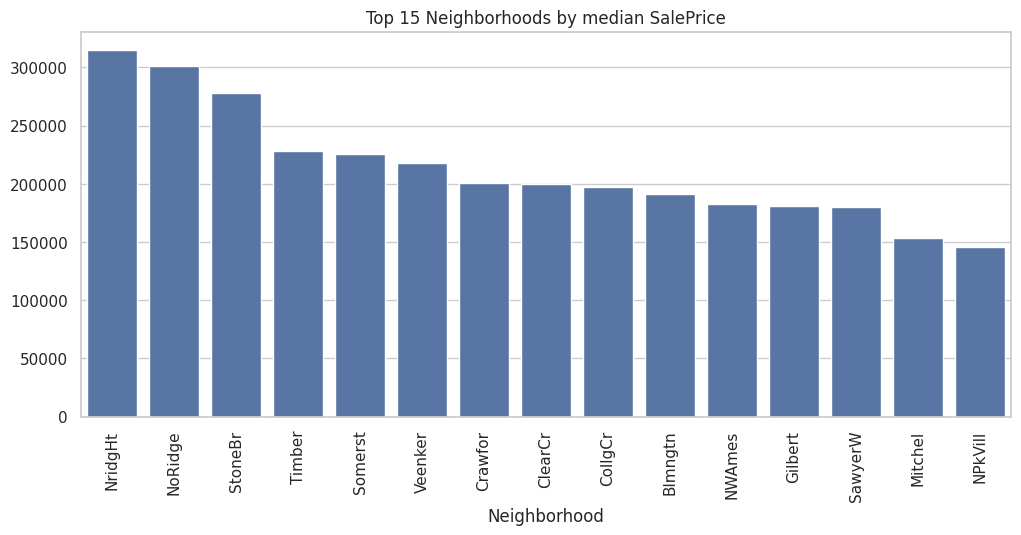

In [97]:
sns.set(style='whitegrid')

# SalePrice distribution
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.show()
plt.close()

# Log(SalePrice) distribution
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice_log'], kde=True)
plt.title('Log(SalePrice) distribution')
plt.show()
plt.close()

# Selected correlation heatmap
cols_corr = [c for c in ['SalePrice','OverallQual','GrLivArea','TotalSF','GarageCars','FullBath'] if c in train.columns]
corr = train[cols_corr].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation (selected features)')
plt.show()
plt.close()

# Neighborhood: top 15 by median SalePrice
neigh_med = train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,5))
sns.barplot(x=neigh_med.index, y=neigh_med.values)
plt.xticks(rotation=90)
plt.title('Top 15 Neighborhoods by median SalePrice')
plt.show()
plt.close()

### Removing Outliers using Interquantile Range(IQR)

In [98]:
# Outlier removal using IQR on GrLivArea and SalePrice
def remove_outliers_iqr(df, col):
    if col not in df.columns:
        return df
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[col] >= lower) & (df[col] <= upper)]

train_before = train.shape[0]
if 'GrLivArea' in train.columns:
    train = remove_outliers_iqr(train, 'GrLivArea')
if 'SalePrice' in train.columns:
    train = remove_outliers_iqr(train, 'SalePrice')
print(f'Removed {train_before - train.shape[0]} outliers from train using IQR (GrLivArea & SalePrice)')

Removed 87 outliers from train using IQR (GrLivArea & SalePrice)


In [99]:
# Prepare X and y (log-target)
y = np.log1p(train['SalePrice'])
X = train.drop(['Id','SalePrice','SalePrice_log'], axis=1, errors='ignore')
X_test = test.drop(['Id'], axis=1, errors='ignore')

In [100]:
# Detect numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Treat some numeric-coded features as categorical
for col in ['MSSubClass','OverallQual','OverallCond']:
    if col in num_cols:
        num_cols.remove(col)
        if col not in cat_cols:
            cat_cols.append(col)

print('Numeric features:', len(num_cols), 'Categorical features:', len(cat_cols))

Numeric features: 38 Categorical features: 46


In [101]:
# Identify ordinal "quality" columns
ord_cols = [c for c in ['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','HeatingQC','FireplaceQu'] if c in X.columns]

### Building Preprocessing Pipelines

In [102]:
# 1) Numeric pipeline: KNN impute + scaling
num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

In [103]:
# 2) Ordinal pipeline: impute then ordinal encode with known order
ord_pipeline = None
if len(ord_cols) > 0:
    quality_order = ['Po','Fa','TA','Gd','Ex']
    ord_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[quality_order]*len(ord_cols)))
    ])

In [104]:
# 3) Categorical pipeline: impute then one-hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Assembling Column Transformer

In [105]:
transformers = []
transformers.append(('num', num_pipeline, num_cols))
transformers.append(('ord', ord_pipeline, ord_cols))

cat_for_transform = [c for c in cat_cols if c not in ord_cols]
transformers.append(('cat', cat_pipeline, cat_for_transform))

preprocessor = ColumnTransformer(transformers, remainder='drop')

### Implementing RandomizedSearchCV to find Optimal Hyperparameters

In [106]:
# Define candidate models and their hyperparameter search spaces
models = {
    'DecisionTree': (DecisionTreeRegressor(random_state=SEED), {
        'model__max_depth': [5,10,15,20,None],
        'model__min_samples_split':[2,5,10]
    }),
    'RandomForest': (RandomForestRegressor(random_state=SEED, n_jobs=-1), {
        'model__n_estimators':[100,200,400],
        'model__max_depth':[10,20,None],
        'model__min_samples_split':[2,5,10]
    }),
    'XGBoost': (xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED, n_jobs=4), {
        'model__n_estimators':[100,200,400],
        'model__max_depth':[3,5,7],
        'model__learning_rate':[0.01,0.05,0.1]
    }),
    'Ridge': (Ridge(), {
        'model__alpha':[0.1,1.0,5.0,10.0,50.0]
    }),
    'Lasso': (Lasso(max_iter=5000), {
        'model__alpha':[0.0005,0.001,0.01,0.1,1.0]
    })
}

In [107]:
# Randomized search for each model
results = {}
for name, (est, param_dist) in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', est)])
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=8,
                            scoring='neg_root_mean_squared_error', cv=5,
                            random_state=SEED, n_jobs=-1, verbose=0)
    rs.fit(X, y)
    best = rs.best_estimator_
    rmse = -rs.best_score_
    results[name] = {'estimator': best, 'rmse': rmse, 'best_params': rs.best_params_}
    print(f'{name} CV RMSE (log-target): {rmse:.4f}, best_params: {rs.best_params_}')

DecisionTree CV RMSE (log-target): 0.1861, best_params: {'model__min_samples_split': 5, 'model__max_depth': 5}
RandomForest CV RMSE (log-target): 0.1340, best_params: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__max_depth': 20}
XGBoost CV RMSE (log-target): 0.1220, best_params: {'model__n_estimators': 400, 'model__max_depth': 3, 'model__learning_rate': 0.05}


/home/adarsh/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=8. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge CV RMSE (log-target): 0.1155, best_params: {'model__alpha': 10.0}


/home/adarsh/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=8. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso CV RMSE (log-target): 0.1125, best_params: {'model__alpha': 0.0005}


### Building Ensemble Learning Model

In [108]:
# Build ensemble from selected trained estimators
ensemble_estimators = []
for key in ('RandomForest','XGBoost','Ridge'):
    if key in results:
        ensemble_estimators.append((key.lower(), results[key]['estimator']))
        
ensemble = VotingRegressor(estimators=ensemble_estimators)

In [109]:
# Cross-validate ensemble and report RMSE (log-target)
ens_scores = cross_val_score(ensemble, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ensemble_rmse = -ens_scores.mean()
print('Ensemble CV RMSE (log-target):', round(ensemble_rmse,4))

Ensemble CV RMSE (log-target): 0.1155


In [110]:
# Fit ensemble on full training data and predict on test set
ensemble.fit(X, y)
preds_log = ensemble.predict(X_test)
preds = np.expm1(preds_log)

In [111]:
# Final summary of model results
print('\nModel RMSE summary (log-target):-')
for name, info in results.items():
    print(f'{name}: RMSE={info["rmse"]:.4f}')
print('Ensemble RMSE:', round(ensemble_rmse,4))


Model RMSE summary (log-target):-
DecisionTree: RMSE=0.1861
RandomForest: RMSE=0.1340
XGBoost: RMSE=0.1220
Ridge: RMSE=0.1155
Lasso: RMSE=0.1125
Ensemble RMSE: 0.1155
